# Lab 02 — Encoder counts to distance calibration (Section 4)

We construct a mapping from forward encoder counts to traveled distance:
\[
s = f_{se}(e)
\]
where \(s\) is distance traveled (m) and \(e\) is the encoder count change.

**Sign convention:** our robot reports negative encoder counts when driving forward, so we define
\[
e_{\text{fwd}} = -\Delta e \ge 0
\]
and fit a line through the origin:
\[
s \approx k_{se}\,e_{\text{fwd}}
\]

We also model distance uncertainty by fitting a variance model through the origin:
\[
\sigma_s^2 \approx k_{ss}\,e_{\text{fwd}}
\]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# Raw calibration data (s in meters, delta encoder counts)
# -----------------------------

data = {
    100: {  # v=100, duration ~3.5s per trial (duration not needed for s vs counts mapping)
        "s_m": [1.015, 1.04, 1.03, 1.11, 1.05, 1.12, 1.15, 1.11, 1.12, 1.16, 1.11, 1.13, 1.095, 1.15],
        "de":  [-3606, -3698, -3479, -3794, -3707, -3947, -3910, -3822, -3913, -3960, -3838, -3907, -3772, -3991],
    },
    60: {   # v=60, duration ~3s
        "s_m": [0.42, 0.43, 0.405, 0.43, 0.45],
        "de":  [-1440, -1497, -1361, -1485, -1555],
    },
    80: {   # v=80, duration ~3s
        "s_m": [0.79, 0.77, 0.79, 0.78, 0.78],
        "de":  [-2759, -2669, -2750, -2734, -2748],
    }
}

# Flatten into arrays
s_all = []
e_fwd_all = []
v_all = []

for v, d in data.items():
    s = np.array(d["s_m"], dtype=float)
    de = np.array(d["de"], dtype=float)
    e_fwd = -de  # forward counts (positive)
    s_all.append(s)
    e_fwd_all.append(e_fwd)
    v_all.append(np.full_like(s, float(v)))

s_all = np.concatenate(s_all)
e_fwd_all = np.concatenate(e_fwd_all)
v_all = np.concatenate(v_all)

print("Total samples:", len(s_all))
print("e_fwd min/max:", e_fwd_all.min(), e_fwd_all.max())
print("s min/max:", s_all.min(), s_all.max())
# -----------------------------

Total samples: 24
e_fwd min/max: 1361.0 3991.0
s min/max: 0.405 1.16


## Step 1 — Fit distance mapping \( s = k_{se} e_{\text{fwd}} \) through the origin

We fit the slope with least squares constrained to pass through \((0,0)\):
\[
k_{se} = \frac{\sum e_{\text{fwd}} s}{\sum e_{\text{fwd}}^2}
\]

In [3]:
# Through-origin fit: s ≈ k_se * e_fwd
k_se = (e_fwd_all @ s_all) / (e_fwd_all @ e_fwd_all)
k_se = float(k_se)

print("k_se (meters per count) =", k_se)

def f_se(e_fwd_counts):
    e = np.asarray(e_fwd_counts, dtype=float)
    return k_se * e

k_se (meters per count) = 0.0002882760254750431


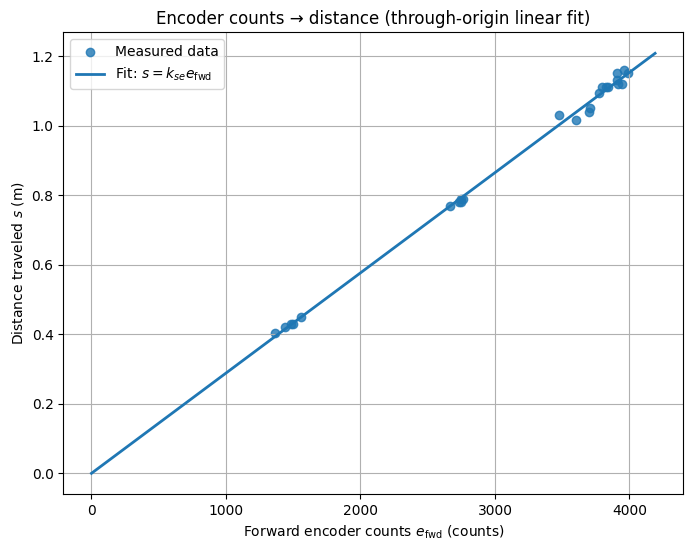

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(e_fwd_all, s_all, alpha=0.8, label="Measured data")

xgrid = np.linspace(0, e_fwd_all.max()*1.05, 250)
plt.plot(xgrid, f_se(xgrid), linewidth=2, label=r"Fit: $s=k_{se} e_{\mathrm{fwd}}$")

plt.xlabel(r"Forward encoder counts $e_{\mathrm{fwd}}$ (counts)")
plt.ylabel(r"Distance traveled $s$ (m)")
plt.title("Encoder counts → distance (through-origin linear fit)")
plt.grid(True)
plt.legend()
plt.show()

## Step 2 — Fit distance variance model \( \sigma_s^2 = k_{ss} e_{\text{fwd}} \) through the origin

For each trial we compute the squared error:
\[
\text{sq\_err} = (s - \hat{s})^2
\]
and fit a straight line through the origin:
\[
\sigma_s^2 \approx k_{ss} e_{\text{fwd}},\quad
k_{ss}=\frac{\sum e_{\text{fwd}}\,\text{sq\_err}}{\sum e_{\text{fwd}}^2}
\]


In [5]:
s_hat = f_se(e_fwd_all)
err = s_all - s_hat
sq_err = err**2

k_ss = (e_fwd_all @ sq_err) / (e_fwd_all @ e_fwd_all)
k_ss = float(max(0.0, k_ss))  # keep nonnegative

print("k_ss (m^2 per count) =", k_ss)

def f_ss(e_fwd_counts):
    e = np.asarray(e_fwd_counts, dtype=float)
    # through-origin line; nonnegative for e>=0
    return k_ss * np.maximum(0.0, e)

k_ss (m^2 per count) = 6.338605358524559e-08


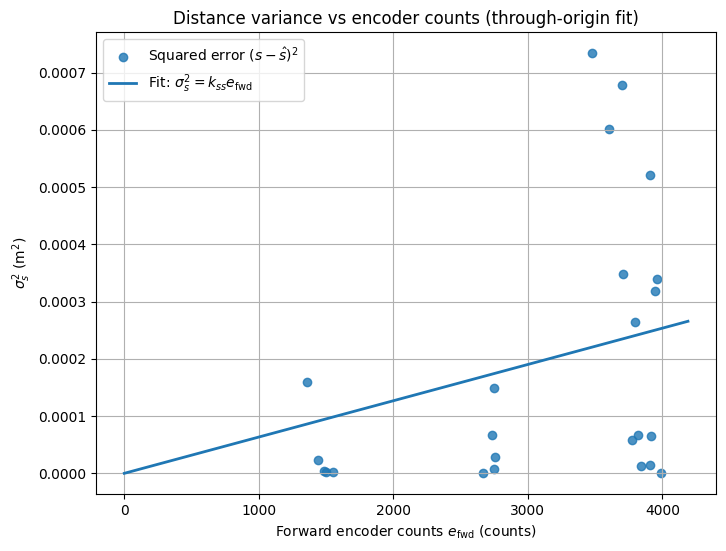

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(e_fwd_all, sq_err, alpha=0.8, label=r"Squared error $(s-\hat{s})^2$")

xgrid = np.linspace(0, e_fwd_all.max()*1.05, 250)
plt.plot(xgrid, f_ss(xgrid), linewidth=2, label=r"Fit: $\sigma_s^2=k_{ss} e_{\mathrm{fwd}}$")

plt.xlabel(r"Forward encoder counts $e_{\mathrm{fwd}}$ (counts)")
plt.ylabel(r"$\sigma_s^2$ (m$^2$)")
plt.title("Distance variance vs encoder counts (through-origin fit)")
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def fit_k_se_through_origin(e_fwd, s):
    return float((e_fwd @ s) / (e_fwd @ e_fwd))

print("Per-speed k_se (m/count):")
for v, d in data.items():
    s = np.array(d["s_m"], dtype=float)
    e_fwd = -np.array(d["de"], dtype=float)
    print(f"  v={v}: k_se =", fit_k_se_through_origin(e_fwd, s))

print("\nGlobal k_se =", k_se)

Per-speed k_se (m/count):
  v=100: k_se = 0.00028851708972299
  v=60: k_se = 0.00029082137647379374
  v=80: k_se = 0.0002862256172248922

Global k_se = 0.0002882760254750431


## Final calibrated functions (for motion_models.py)

We will use:
\[
s = k_{se} e_{\mathrm{fwd}},\qquad \sigma_s^2 = k_{ss} e_{\mathrm{fwd}}
\]
Copy the printed values of \(k_{se}\) and \(k_{ss}\) into `motion_models.py`.


In [8]:
print("---- paste into motion_models.py ----")
print(f"K_SE = {k_se:.18e}  # meters per count")
print(f"K_SS = {k_ss:.18e}  # (m^2) per count")

---- paste into motion_models.py ----
K_SE = 2.882760254750430982e-04  # meters per count
K_SS = 6.338605358524558586e-08  # (m^2) per count
